## Algorithms

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, mean_squared_error, roc_auc_score
import seaborn as sns
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
# LOAD PREPROCESSED DATA
# Loads the dataset prepared in the preprocessing notebook.
# This ensures consistency across all algorithms.
df = pd.read_csv("processed_books.csv")
df.head()

,title,author,genres,description,rating,numRatings,likedPercent,recommended,log_reviews,text,text_length
0,The Hunger Games,Suzanne Collins,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,4.33,6376780,96.0,1,15.668174,the hunger games suzanne collins ['young adult...,165
1,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)","['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",There is a door at the end of a silent corrido...,4.50,2507623,98.0,1,14.734846,harry potter and the order of the phoenix j.k....,163
2,To Kill a Mockingbird,Harper Lee,"['Classics', 'Fiction', 'Historical Fiction', ...",The unforgettable novel of a childhood in a sl...,4.28,4501075,95.0,1,15.319827,"to kill a mockingbird harper lee ['classics', ...",158
3,Pride and Prejudice,"Jane Austen, Anna Quindlen (Introduction)","['Classics', 'Fiction', 'Romance', 'Historical...",Alternate cover edition of ISBN 9780679783268S...,4.26,2998241,94.0,1,14.913537,"pride and prejudice jane austen, anna quindlen...",121
4,Twilight,Stephenie Meyer,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",About three things I was absolutely positive.\...,3.60,4964519,78.0,0,15.417827,"twilight stephenie meyer ['young adult', 'fant...",71


In [3]:
X = df.drop("recommended", axis=1)
y = df["recommended"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30,random_state=42)

### Model 1: Logistic Regression

In [4]:
tfidf = TfidfVectorizer(stop_words="english", max_features=50000)

X_train_text = tfidf.fit_transform(X_train["text"])
X_test_text = tfidf.transform(X_test["text"])

X_train_num = csr_matrix(X_train[["log_reviews", "rating"]].values)
X_test_num = csr_matrix(X_test[["log_reviews", "rating"]].values)

X_train_lr = hstack([X_train_text, X_train_num])
X_test_lr = hstack([X_test_text, X_test_num])

In [5]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_lr, y_train)

y_pred_lr = lr.predict(X_test_lr)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      3593
           1       0.91      0.96      0.93     12124

    accuracy                           0.90     15717
   macro avg       0.87      0.82      0.84     15717
weighted avg       0.89      0.90      0.89     15717

[[ 2466  1127]
 [  514 11610]]


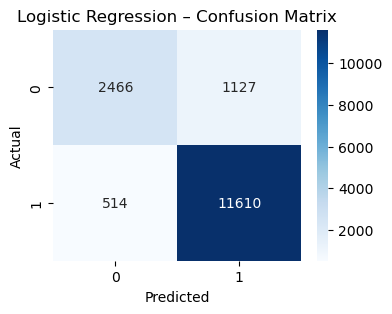

In [6]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_lr),
            annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

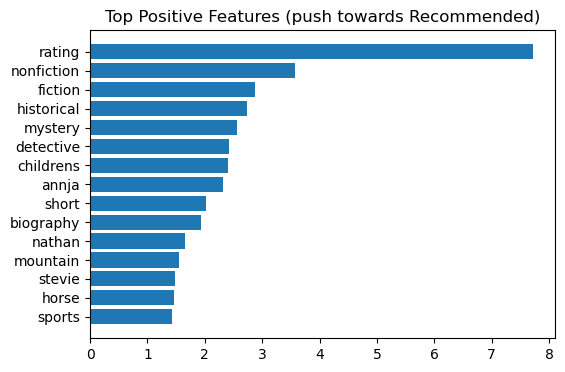

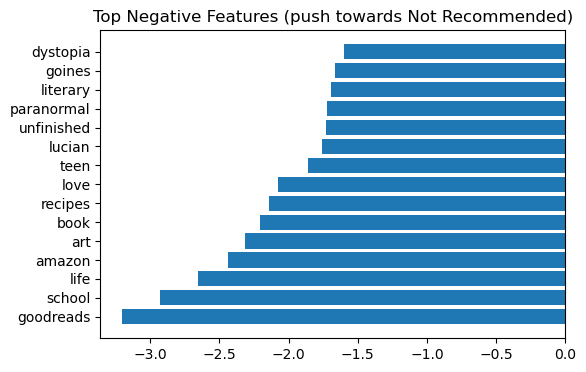

In [7]:
# get top words from LR
feature_names = np.array(tfidf.get_feature_names_out().tolist() + ["log_reviews", "rating"])
coefs = lr.coef_[0]
top_pos_idx = np.argsort(coefs)[-15:]
top_neg_idx = np.argsort(coefs)[:15]

plt.figure(figsize=(6,4))
plt.barh(feature_names[top_pos_idx], coefs[top_pos_idx])
plt.title("Top Positive Features (push towards Recommended)")
plt.show()
plt.figure(figsize=(6,4))
plt.barh(feature_names[top_neg_idx], coefs[top_neg_idx])
plt.title("Top Negative Features (push towards Not Recommended)")
plt.show()

### Model 2: Random Forest

In [22]:
# small TF-IDF so RF won't explode memory
tfidf_rf = TfidfVectorizer(stop_words="english", max_features=600, dtype=np.float32)

X_train_text_rf = tfidf_rf.fit_transform(X_train["text"]).toarray()  # small so dense is ok
X_test_text_rf = tfidf_rf.transform(X_test["text"]).toarray()

X_train_rf = np.hstack([X_train_text_rf, X_train[["log_reviews", "rating"]].values.astype(np.float32)])
X_test_rf = np.hstack([X_test_text_rf, X_test[["log_reviews", "rating"]].values.astype(np.float32)])

# -------- BUILD FULL DATASET FEATURES FOR RANDOM FOREST --------

# TF-IDF text features (same vectorizer, same size = 600)
X_text_all_rf = tfidf_rf.transform(df["text"]).toarray()

# Numeric features (same as training)
X_num_all_rf = df[["log_reviews", "rating"]].values.astype(np.float32)

# Combine text + numeric features
X_all_rf = np.hstack([X_text_all_rf, X_num_all_rf])

# print("X_all_rf shape:", X_all_rf.shape)

rf = RandomForestClassifier(random_state=42, n_estimators=150)
rf.fit(X_train_rf, y_train)

pred_rf = rf.predict(X_test_rf)

print("RANDOM FOREST")
print(classification_report(y_test, pred_rf))

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.85      0.69      0.76      3593
           1       0.91      0.96      0.94     12124

    accuracy                           0.90     15717
   macro avg       0.88      0.83      0.85     15717
weighted avg       0.90      0.90      0.90     15717



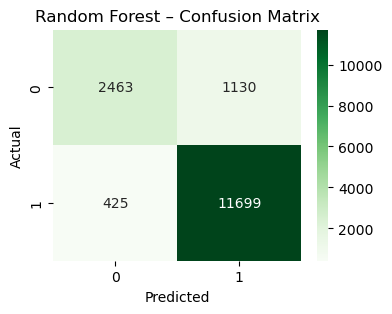

In [9]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, pred_rf),
            annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Model 3: k-NN

In [10]:
tfidf_knn = TfidfVectorizer(stop_words="english", max_features=5000)

X_train_text_knn = tfidf_knn.fit_transform(X_train["text"])
X_test_text_knn = tfidf_knn.transform(X_test["text"])

X_train_num_knn = csr_matrix(X_train[["log_reviews", "rating"]].values)
X_test_num_knn = csr_matrix(X_test[["log_reviews", "rating"]].values)

X_train_knn = hstack([X_train_text_knn, X_train_num_knn])
X_test_knn = hstack([X_test_text_knn, X_test_num_knn])

knn = KNeighborsClassifier(n_neighbors=5, metric="cosine")
knn.fit(X_train_knn, y_train)

pred_knn = knn.predict(X_test_knn)

print("K-NN")
print(classification_report(y_test, pred_knn))

K-NN
              precision    recall  f1-score   support

           0       0.26      0.15      0.19      3593
           1       0.78      0.87      0.82     12124

    accuracy                           0.71     15717
   macro avg       0.52      0.51      0.51     15717
weighted avg       0.66      0.71      0.68     15717



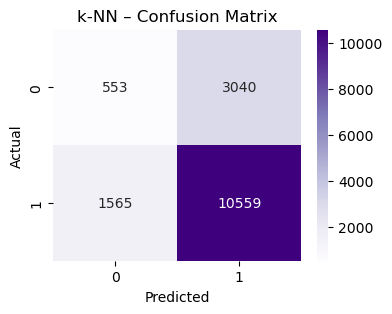

In [11]:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, pred_knn),
            annot=True, fmt="d", cmap="Purples")
plt.title("k-NN – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Comparing Accuracies

In [12]:
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, pred_rf)
acc_knn = accuracy_score(y_test, pred_knn)

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "k-NN"],
    "Accuracy": [acc_lr, acc_rf, acc_knn]
}).sort_values("Accuracy", ascending=False)

results

,Model,Accuracy
1,Random Forest,0.901063
0,Logistic Regression,0.895591
2,k-NN,0.707005


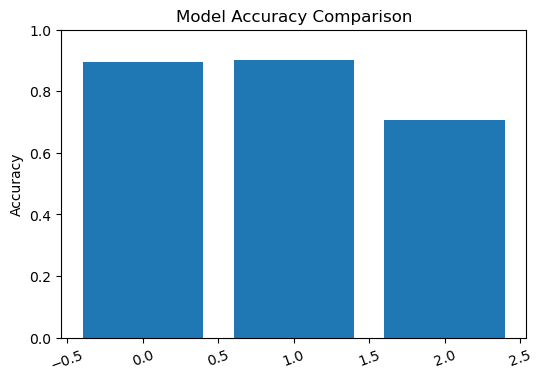

In [13]:
plt.figure(figsize=(6, 4))
plt.bar(results.index, results["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=20)
plt.ylim(0, 1)
plt.show()

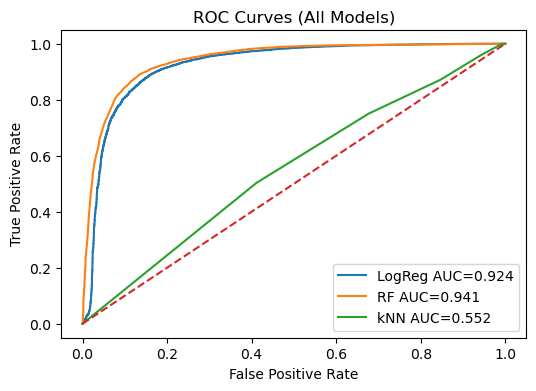

In [14]:
#ROC Curve and AUC Comparison
plt.figure(figsize=(6,4))

# Logistic Regression probs
lr_probs = lr.predict_proba(X_test_lr)[:, 1]
fpr, tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(fpr, tpr, label=f"LogReg AUC={auc(fpr,tpr):.3f}")

# Random Forest probs
rf_probs = rf.predict_proba(X_test_rf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.plot(fpr, tpr, label=f"RF AUC={auc(fpr,tpr):.3f}")

# k-NN probs 
knn_probs = knn.predict_proba(X_test_knn)[:, 1]
fpr, tpr, _ = roc_curve(y_test, knn_probs)
plt.plot(fpr, tpr, label=f"kNN AUC={auc(fpr,tpr):.3f}")

plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curves (All Models)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Mean Squared Error

In [30]:
def prob_metrics(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "MSE": mean_squared_error(y_test, y_prob),  # MSE on probabilities
    }

metrics_lr = prob_metrics(lr, X_test_lr, y_test)  
metrics_rf = prob_metrics(rf, X_test_rf, y_test)    
metrics_knn = prob_metrics(knn, X_test_knn, y_test)  

import pandas as pd
results_df = pd.DataFrame(
    [metrics_lr, metrics_rf, metrics_knn],
    index=["Logistic Regression", "Random Forest", "k-NN"]
)

results_df

,MSE
Logistic Regression,0.079202
Random Forest,0.077444
k-NN,0.218009


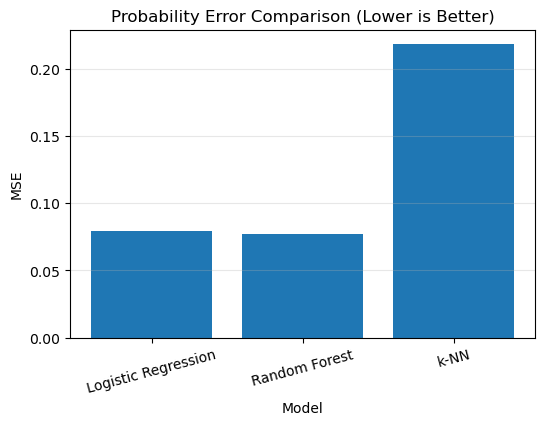

In [32]:
plt.figure(figsize=(6, 4))

plt.bar(
    results_df.index,
    results_df["MSE"]
)

plt.ylabel("MSE")
plt.xlabel("Model")
plt.title("Probability Error Comparison (Lower is Better)")
plt.xticks(rotation=15)
plt.grid(axis="y", alpha=0.3)

plt.show()

### APPLICATION 


In [25]:
# -------- MODE 1: USER INPUT → RECOMMENDED / NOT RECOMMENDED --------

print("\nCHECK IF A BOOK SHOULD BE RECOMMENDED\n")

book_name = input("Book name: ").strip()
book_description = input("Book description / keywords: ").strip()
book_rating = float(input("Book rating (1–5): "))
book_num_ratings = int(input("Number of ratings: "))

if not book_description:
    print("Description is required.")
else:
    # Text features
    text_vector = tfidf_rf.transform([book_description]).toarray()

    # Numeric features
    log_reviews = np.log1p(book_num_ratings)
    num_features = np.array([[log_reviews, book_rating]])

    # Combine features
    X_user = np.hstack([text_vector, num_features])

    # Predict using Random Forest
    probability = rf.predict_proba(X_user)[0][1]

    print(f"\nRecommendation Result for '{book_name}':")
    print(f"Recommendation Probability: {probability:.2f}")

    if probability >= 0.5:
        print("This book IS RECOMMENDED")
    else:
        print("This book IS NOT RECOMMENDED")
#Dummy inputs
# Harry Potter and the Philosopher's Stone: fantasy magic wizard school adventure friendship, 4.8, 9000000
# Fragments of Silence: experimental fragmented narrative abstract unclear slow pacing, 2.6, 28


CHECK IF A BOOK SHOULD BE RECOMMENDED



Book name:  Fragments of Silence
Book description / keywords:  experimental fragmented narrative abstract unclear slow pacing
Book rating (1–5):  2.6
Number of ratings:  28



Recommendation Result for 'Fragments of Silence':
Recommendation Probability: 0.00
This book IS NOT RECOMMENDED


In [28]:
# -------- MODE 2: USER INPUT → TOP 5 RECOMMENDED BOOKS --------

tfidf_sim = TfidfVectorizer(stop_words="english", max_features=20000)
X_sim = tfidf_sim.fit_transform(df["text"])

print("BOOK RECOMMENDATION SYSTEM – TOP 5 BOOKS\n")

# User input
user_text = input("Enter keywords / description of the book you want: ").strip()
min_rating = float(input("Minimum rating (0 to skip): ") or 0)
min_num_ratings = int(input("Minimum number of ratings (0 to skip): ") or 0)

if not user_text:
    print("Please enter some keywords.")
else:
    # Text similarity (relevance)
    user_vec = tfidf_sim.transform([user_text])
    similarity_scores = cosine_similarity(user_vec, X_sim).ravel()

    # Random Forest probability (quality)
    rf_probs = rf.predict_proba(X_all_rf)[:, 1]

    # Combine scores internally
    alpha = 0.6
    final_score = alpha * rf_probs + (1 - alpha) * similarity_scores

    # Apply user filters
    mask = (df["rating"] >= min_rating) & (df["numRatings"] >= min_num_ratings)

    # Sort indices by final score
    ranked_indices = (
        df.loc[mask]
        .assign(score=final_score[mask.values])
        .sort_values("score", ascending=False)
        .index
    )

    top5_books = df.loc[
        ranked_indices,
        ["title", "author", "genres", "rating", "numRatings"]
    ].head(5)

    print("\nTop 5 Recommended Books:")
    display(top5_books)


BOOK RECOMMENDATION SYSTEM – TOP 5 BOOKS



Enter keywords / description of the book you want:  fantasy magic adventure epic journey young adult
Minimum rating (0 to skip):  4
Minimum number of ratings (0 to skip):  10000



Top 5 Recommended Books:


,title,author,genres,rating,numRatings
1214,The Great Hunt,Robert Jordan,"['Fantasy', 'Fiction', 'Epic Fantasy', 'High F...",4.22,227837
7796,The Druid of Shannara,Terry Brooks (Goodreads Author),"['Fantasy', 'Fiction', 'Epic Fantasy', 'Scienc...",4.02,30463
13939,The Riftwar Saga,Raymond E. Feist,"['Fantasy', 'Epic Fantasy', 'High Fantasy', 'F...",4.40,11246
3123,A Crown of Swords,Robert Jordan,"['Fantasy', 'Fiction', 'Epic Fantasy', 'Scienc...",4.03,126307
2835,The Night Angel Trilogy,Brent Weeks (Goodreads Author),"['Fantasy', 'Fiction', 'Epic Fantasy', 'Magic'...",4.42,23660
